### Understanding the Data

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Download stopwords if not already
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Download WordNet if not already
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\37789\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\37789\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\37789\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [75]:
train_df = pd.read_csv("../Dataset/LIAR DATASET/train.tsv", sep='\t', header=None)
valid_df = pd.read_csv("../Dataset/LIAR DATASET/valid.tsv", sep='\t', header=None)
test_df  = pd.read_csv("../Dataset/LIAR DATASET/test.tsv", sep='\t', header=None)

In [76]:
columns = [
    "id", "label", "statement", "subject", "speaker", "job_title", 
    "state", "party", "barely_true", "false", "half_true", 
    "mostly_true", "pants_fire", "context"
]

train_df.columns = columns
valid_df.columns = columns
test_df.columns  = columns


In [77]:
# First few rows
train_df.head()

,id,label,statement,subject,speaker,job_title,state,party,barely_true,false,half_true,mostly_true,pants_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [78]:
# Combine missing values side by side
missing_summary = pd.concat([
    train_df.isnull().sum().rename('Train'),
    valid_df.isnull().sum().rename('Validation'),
    test_df.isnull().sum().rename('Test')
], axis=1)

print(missing_summary)

             Train  Validation  Test
id               0           0     0
label            0           0     0
statement        0           0     0
subject          2           0     0
speaker          2           0     0
job_title     2898         345   325
state         2210         279   262
party            2           0     0
barely_true      2           0     0
false            2           0     0
half_true        2           0     0
mostly_true      2           0     0
pants_fire       2           0     0
context        102          12    17


In [79]:
# Class distribution
train_df["label"].value_counts()

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

In [80]:
print("Train:", len(train_df))
print("Validation:", len(valid_df))
print("Test:", len(test_df))


Train: 10240
Validation: 1284
Test: 1267


In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10240 non-null  object 
 1   label        10240 non-null  object 
 2   statement    10240 non-null  object 
 3   subject      10238 non-null  object 
 4   speaker      10238 non-null  object 
 5   job_title    7342 non-null   object 
 6   state        8030 non-null   object 
 7   party        10238 non-null  object 
 8   barely_true  10238 non-null  float64
 9   false        10238 non-null  float64
 10  half_true    10238 non-null  float64
 11  mostly_true  10238 non-null  float64
 12  pants_fire   10238 non-null  float64
 13  context      10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


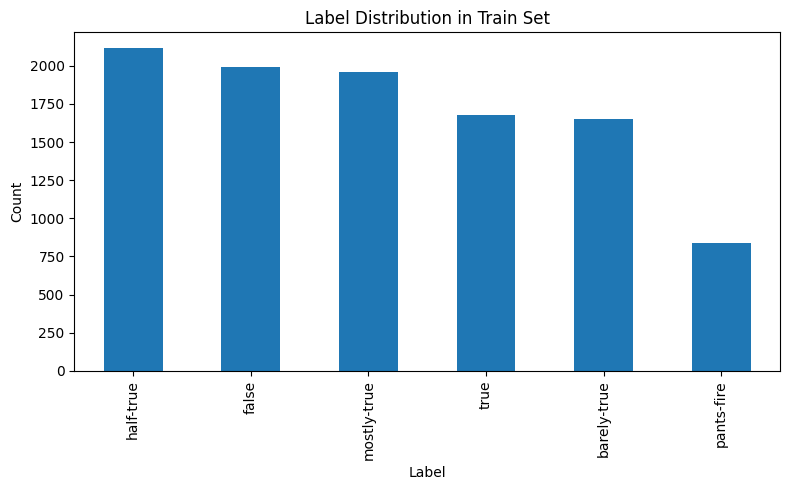

In [82]:
plt.figure(figsize=(8,5))
train_df["label"].value_counts().plot(kind='bar')
plt.title("Label Distribution in Train Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [83]:
# Separate categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'context']
Numerical features: ['barely_true', 'false', 'half_true', 'mostly_true', 'pants_fire']


##### Dropping `id` column  
- The `id` column is just a unique identifier and does not provide any predictive power. We will drop it from our dataset before training the model.


In [84]:
# Drop 'id' column from train, valid, and test datasets
train_df = train_df.drop(columns=["id"])
valid_df = valid_df.drop(columns=["id"])
test_df = test_df.drop(columns=["id"])

In [85]:
# Drop rows with missing numerical values
train_df = train_df.dropna(subset=['barely_true', 'false', 'half_true', 'mostly_true', 'pants_fire'])
valid_df = valid_df.dropna(subset=['barely_true', 'false', 'half_true', 'mostly_true', 'pants_fire'])
test_df  = test_df.dropna(subset=['barely_true', 'false', 'half_true', 'mostly_true', 'pants_fire'])

##### Encoding the `label` Column
- We map the textual labels to numbers because machine learning models require numerical targets.  
- Each class is assigned a unique number. Although the numbers are ordered, they do **not** imply importance or magnitude; they are just identifiers for the classifier.


In [86]:
# Define the mapping
label_mapping = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

# Apply the mapping to train, valid, and test datasets
train_df["label"] = train_df["label"].map(label_mapping)
valid_df["label"] = valid_df["label"].map(label_mapping)
test_df["label"]  = test_df["label"].map(label_mapping)

# Verify
train_df["label"].value_counts()


label
3    2114
1    1993
4    1962
5    1676
2    1654
0     839
Name: count, dtype: int64

#### Handling "Context"

In [87]:
print("Unique contexts in train:", train_df['context'].unique())
print("Number of unique contexts:", train_df['context'].nunique())

Unique contexts in train: ['a mailer' 'a floor speech.' 'Denver' ...
 'a recorded telephone message to Cranston residents'
 'interview on "The Colbert Report"'
 "a televised debate on Miami's WPLG-10 against Kendrick Meek."]
Number of unique contexts: 4345


### Dropping 'context' Feature
- We are dropping the 'context' feature because it has **extremely high cardinality** (4,345 unique values).  
- One-Hot Encoding would create thousands of sparse columns, which is inefficient and may not improve model performance.  
- Most of the textual information is already captured in the 'statement' column, so dropping 'context' is a practical choice for this project.


In [88]:
# Drop 'context' column from train, valid, and test datasets
train_df = train_df.drop(columns=['context'])
valid_df = valid_df.drop(columns=['context'])
test_df  = test_df.drop(columns=['context'])


In [89]:
missing_summary = pd.concat([
    train_df.isnull().sum().rename('Train_Missing'),
    valid_df.isnull().sum().rename('Validation_Missing'),
    test_df.isnull().sum().rename('Test_Missing'),
    train_df.dtypes.rename('Dtype')
], axis=1)

print(missing_summary)


             Train_Missing  Validation_Missing  Test_Missing    Dtype
label                    0                   0             0    int64
statement                0                   0             0   object
subject                  0                   0             0   object
speaker                  0                   0             0   object
job_title             2896                 345           325   object
state                 2208                 279           262   object
party                    0                   0             0   object
barely_true              0                   0             0  float64
false                    0                   0             0  float64
half_true                0                   0             0  float64
mostly_true              0                   0             0  float64
pants_fire               0                   0             0  float64


In [90]:
# Check unique values in categorical features
for col in ["subject", "speaker", "party"]:
    print(f"Unique {col} in train: {train_df[col].nunique()}")
    print(f"Unique {col} in valid: {valid_df[col].nunique()}")
    print(f"Unique {col} in test:  {test_df[col].nunique()}")
    print("-" * 40)

Unique subject in train: 3827
Unique subject in valid: 734
Unique subject in test:  732
----------------------------------------
Unique speaker in train: 2910
Unique speaker in valid: 662
Unique speaker in test:  636
----------------------------------------
Unique party in train: 23
Unique party in valid: 16
Unique party in test:  16
----------------------------------------


### Handling `party` Feature  

We are keeping the **party** feature because political affiliation is often strongly correlated with the type of statements made and their truthfulness.  

- **Why One-Hot Encoding?**  
  - `party` has only 23 unique categories, which is a manageable number.  
  - One-hot encoding avoids introducing any false ordering (which would happen with label encoding).  
  - It keeps the feature interpretable and works well with most machine learning algorithms.  

- **Why not other methods?**  
  - *Label Encoding*: Imposes an artificial ranking among parties (e.g., republican > democrat), which doesn’t make sense.  
  - *Frequency Encoding*: Would compress categories into a single number but lose interpretability.  
  - *Dropping the feature*: Would discard potentially useful information.  

👉 Therefore, we apply **One-Hot Encoding** to `party`.


In [91]:
# One-hot encode 'party' for train, valid, and test
train_df = pd.get_dummies(train_df, columns=["party"], prefix="party")
valid_df = pd.get_dummies(valid_df, columns=["party"], prefix="party")
test_df  = pd.get_dummies(test_df,  columns=["party"], prefix="party")

# Align columns so all datasets have the same structure
train_df, valid_df = train_df.align(valid_df, join='left', axis=1, fill_value=0)
train_df, test_df  = train_df.align(test_df,  join='left', axis=1, fill_value=0)

# Convert one-hot columns to integers
party_cols = [col for col in train_df.columns if col.startswith("party_")]
train_df[party_cols] = train_df[party_cols].astype(int)
valid_df[party_cols] = valid_df[party_cols].astype(int)
test_df[party_cols]  = test_df[party_cols].astype(int)

print("Train shape:", train_df.shape)
print("Validation shape:", valid_df.shape)
print("Test shape:", test_df.shape)

Train shape: (10238, 34)
Validation shape: (1284, 34)
Test shape: (1267, 34)


### Handling `subject` Feature  

We are keeping the **subject** feature because it provides information about the topic of the statement, which can be useful for predicting its veracity.  

- **Why TF-IDF vectorization?**  
  - `subject` has very high cardinality (~3800 unique values), making one-hot encoding impractical.  
  - TF-IDF converts text into numerical features while preserving semantic information.  
  - Allows the model to understand similarities between topics (e.g., "healthcare" and "medicare").  

- **Why not other methods?**  
  - *One-hot Encoding*: Too many columns → inefficient and sparse.  
  - *Label Encoding*: Imposes artificial ordering → meaningless for categories.  
  - *Dropping the feature*: Would lose potentially useful predictive information.  

👉 Therefore, we apply **TF-IDF vectorization** to `subject`.


In [92]:
# Join subject text (if necessary) - here it's already a string
train_subjects = train_df['subject'].fillna("").astype(str)
valid_subjects = valid_df['subject'].fillna("").astype(str)
test_subjects  = test_df['subject'].fillna("").astype(str)

# Initialize TF-IDF vectorizer for subject
tfidf_subject = TfidfVectorizer(max_features=500)  # limit to 500 for efficiency

# Fit on train and transform train, valid, test
X_train_subject = tfidf_subject.fit_transform(train_subjects)
X_valid_subject = tfidf_subject.transform(valid_subjects)
X_test_subject  = tfidf_subject.transform(test_subjects)

print("Shape of train subject features:", X_train_subject.shape)

Shape of train subject features: (10238, 178)


In [93]:
train_df = train_df.drop(columns=['subject'])
valid_df = valid_df.drop(columns=['subject'])
test_df  = test_df.drop(columns=['subject'])

### Handling `speaker` Feature

We are keeping the **speaker** feature because some speakers may consistently make statements with certain veracity patterns, which can help the model.

- **Why Frequency Encoding?**
  - `speaker` has very high cardinality (~2910 unique values), so one-hot encoding would create too many sparse columns.
  - Frequency encoding replaces each speaker with the number of statements they have in the training set.
  - This converts the feature into a meaningful numerical value without exploding dimensionality.

- **Why not other methods?**
  - *One-hot Encoding*: Creates thousands of columns → inefficient.
  - *Label Encoding*: Artificial ordering → meaningless.
  - *TF-IDF*: Not very informative for proper names.
  - *Dropping the feature*: Loses potentially useful predictive information.

👉 Therefore, we apply **frequency encoding** to `speaker`.


In [94]:
# Calculate frequency of each speaker in train set
speaker_freq = train_df['speaker'].value_counts().to_dict()

# Overwrite 'speaker' column with frequency encoding
train_df['speaker'] = train_df['speaker'].map(speaker_freq).fillna(0)
valid_df['speaker'] = valid_df['speaker'].map(speaker_freq).fillna(0)
test_df['speaker']  = test_df['speaker'].map(speaker_freq).fillna(0)

### Handling `state` Feature 

In [95]:
# Fill missing state values with 'Unknown'
train_df['state'] = train_df['state'].fillna('Unknown')
valid_df['state'] = valid_df['state'].fillna('Unknown')
test_df['state']  = test_df['state'].fillna('Unknown')

# Check unique values for manual inspection
print("Unique states in train:", train_df['state'].unique())
print("Number of unique states:", len(train_df['state'].unique()))


Unique states in train: ['Texas' 'Virginia' 'Illinois' 'Unknown' 'Florida' 'Wisconsin'
 'New Jersey' 'Vermont' 'Massachusetts' 'Maryland' 'Washington, D.C. '
 'Oregon' 'New York' 'Washington, D.C.' 'California' 'Missouri'
 'Rhode Island' 'West Virginia' 'Arkansas' 'New Hampshire' 'Ohio'
 'Georgia' 'Arizona' 'Wyoming' 'Delaware' 'Kentucky' 'Kansas' 'ohio'
 'Colorado' 'North Carolina' 'New Mexico' 'Illinois ' 'Alaska'
 'South Carolina' 'Minnesota' 'Tennessee' 'Pennsylvania' 'Iowa'
 'Connecticut' 'Louisiana' 'Indiana' 'Florida ' 'Utah' 'Michigan'
 'Oklahoma' 'Nevada' 'Oregon ' 'Virgina' 'Nebraska' 'Georgia '
 'Washington D.C.' 'California ' 'Massachusetts ' 'Alabama' 'Russia'
 'Washington state' 'Washington' 'District of Columbia' 'Colorado '
 'New Hampshire ' 'Mississippi' 'Rhode island' 'China' 'United Kingdom'
 'Virginia ' 'South Dakota' 'Qatar' 'Montana' 'North Dakota' 'Idaho'
 'Maine' 'New York ' 'Virginia director, Coalition to Stop Gun Violence'
 'Virgiia' 'Hawaii' 'Atlanta' 'Tenne

We filled missing values in the 'state' column with 'Unknown' to retain all rows for modeling. 
This ensures that missing information is explicitly represented without dropping data. 
We then print the unique values to manually inspect and standardize inconsistent entries (e.g., typos, extra spaces, duplicate names) before encoding.


We cleaned and standardized the 'state' column to remove duplicates, fix typos, and handle inconsistent formatting. 
This ensures that each unique state is represented consistently, preventing unnecessary duplication of one-hot encoded columns 
and maintaining meaningful categorical features for the model. Non-state entries and missing values were mapped to 'Other' or 'Unknown'.


In [96]:
# Updated mapping for cleaning and standardizing state names
state_mapping = {
    'ohio': 'Ohio',
    'Virgina': 'Virginia',
    'Virgiia': 'Virginia',
    'Virginia ': 'Virginia',
    'Tex': 'Texas',
    'Florida ': 'Florida',
    'Massachusetts ': 'Massachusetts',
    'Illinois ': 'Illinois',
    'Rhode island': 'Rhode Island',
    'Rhode Island ': 'Rhode Island',
    'Washington, D.C.': 'Washington D.C.',
    'Washington, D.C. ': 'Washington D.C.',
    'Washington D.C.': 'Washington D.C.',
    'Washington DC': 'Washington D.C.',
    'District of Columbia': 'Washington D.C.',
    'Washington state': 'Washington',
    'PA - Pennsylvania': 'Pennsylvania',
    'Atlanta': 'Other',
    'Russia': 'Other',
    'China': 'Other',
    'United Kingdom': 'Other',
    'the United States': 'Other',
    'New Hampshire ': 'New Hampshire',
    'California ': 'California',
    'Wisconsin ': 'Wisconsin',
    'Unknown': 'Other',
    'Oregon ': 'Oregon',
    'Georgia ': 'Georgia',
    'New York ': 'New York',
    'Colorado ': 'Colorado',
    'Qatar': 'Other',
    'Virginia director, Coalition to Stop Gun Violence': 'Virginia',
    'Tennesse': 'Tennessee'
}

# Apply mapping and fill remaining NaNs with 'Other'
for df in [train_df, valid_df, test_df]:
    df['state'] = df['state'].replace(state_mapping).fillna('Other')

# Display unique states after cleaning
print("Unique states after cleaning:", train_df['state'].unique())
print("Number of unique states:", len(train_df['state'].unique()))

# One-hot encode
train_df = pd.get_dummies(train_df, columns=['state'], prefix='state')
valid_df = pd.get_dummies(valid_df, columns=['state'], prefix='state')
test_df  = pd.get_dummies(test_df,  columns=['state'], prefix='state')

# Align columns so train/valid/test all have same structure
train_df, valid_df = train_df.align(valid_df, join='left', axis=1, fill_value=0)
train_df, test_df  = train_df.align(test_df,  join='left', axis=1, fill_value=0)


Unique states after cleaning: ['Texas' 'Virginia' 'Illinois' 'Other' 'Florida' 'Wisconsin' 'New Jersey'
 'Vermont' 'Massachusetts' 'Maryland' 'Washington D.C.' 'Oregon'
 'New York' 'California' 'Missouri' 'Rhode Island' 'West Virginia'
 'Arkansas' 'New Hampshire' 'Ohio' 'Georgia' 'Arizona' 'Wyoming'
 'Delaware' 'Kentucky' 'Kansas' 'Colorado' 'North Carolina' 'New Mexico'
 'Alaska' 'South Carolina' 'Minnesota' 'Tennessee' 'Pennsylvania' 'Iowa'
 'Connecticut' 'Louisiana' 'Indiana' 'Utah' 'Michigan' 'Oklahoma' 'Nevada'
 'Nebraska' 'Alabama' 'Washington' 'Mississippi' 'South Dakota' 'Montana'
 'North Dakota' 'Idaho' 'Maine' 'Hawaii']
Number of unique states: 52


In [97]:
# Drop the original 'state' column if it still exists
for df in [train_df, valid_df, test_df]:
    if 'state' in df.columns:
        df.drop(columns=['state'], inplace=True)

### Drop 'job_title' column
We are dropping the 'job_title' column because it has very high cardinality, many missing values, and sparse unique entries. 
Encoding it (via one-hot, frequency, or label encoding) would either create too many columns or introduce noise. 
Other features like 'statement', 'state', and 'party' already provide strong information for the model.


In [98]:
# Drop 'job_title' from train, valid, and test datasets
train_df = train_df.drop(columns=['job_title'])
valid_df = valid_df.drop(columns=['job_title'])
test_df  = test_df.drop(columns=['job_title'])

##### Basic text cleaning

In [99]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply to train, valid, and test
train_df['statement_clean'] = train_df['statement'].apply(clean_text)
valid_df['statement_clean'] = valid_df['statement'].apply(clean_text)
test_df['statement_clean']  = test_df['statement'].apply(clean_text)

# Preview
train_df[['statement', 'statement_clean']].head()

,statement,statement_clean
0,Says the Annies List political group supports ...,says annies list political group supports thir...
1,When did the decline of coal start? It started...,decline coal start started natural gas took st...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,The economic turnaround started at the end of ...,economic turnaround started end term


##### Tokenization

In [100]:
# Simple whitespace tokenization
train_df['tokens'] = train_df['statement_clean'].apply(lambda x: x.split())
valid_df['tokens'] = valid_df['statement_clean'].apply(lambda x: x.split())
test_df['tokens']  = test_df['statement_clean'].apply(lambda x: x.split())

In [101]:
# Preview
train_df[['statement_clean', 'tokens']].head()

,statement_clean,tokens
0,says annies list political group supports thir...,"[says, annies, list, political, group, support..."
1,decline coal start started natural gas took st...,"[decline, coal, start, started, natural, gas, ..."
2,hillary clinton agrees john mccain voting give...,"[hillary, clinton, agrees, john, mccain, votin..."
3,health care reform legislation likely mandate ...,"[health, care, reform, legislation, likely, ma..."
4,economic turnaround started end term,"[economic, turnaround, started, end, term]"


#### Normalizing 

##### Lemmatization of Tokens
- We use **lemmatization** instead of stemming because it preserves the actual dictionary form of words, maintaining their meaning. This is crucial for Fake News detection, where subtle differences in word meaning can affect the model's understanding.  
- Stemming, on the other hand, produces non-words and may reduce the quality of features.


In [102]:
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

train_df['tokens_lem'] = train_df['tokens'].apply(lemmatize_tokens)
valid_df['tokens_lem'] = valid_df['tokens'].apply(lemmatize_tokens)
test_df['tokens_lem']  = test_df['tokens'].apply(lemmatize_tokens)

# Preview
train_df[['tokens', 'tokens_lem']].head()

,tokens,tokens_lem
0,"[says, annies, list, political, group, support...","[say, annies, list, political, group, support,..."
1,"[decline, coal, start, started, natural, gas, ...","[decline, coal, start, started, natural, gas, ..."
2,"[hillary, clinton, agrees, john, mccain, votin...","[hillary, clinton, agrees, john, mccain, votin..."
3,"[health, care, reform, legislation, likely, ma...","[health, care, reform, legislation, likely, ma..."
4,"[economic, turnaround, started, end, term]","[economic, turnaround, started, end, term]"


#### Feature extraction / Vectorization

##### TF-IDF Vectorization
We use **TF-IDF (Term Frequency–Inverse Document Frequency)** to convert the lemmatized tokens into numeric features.  

**Why TF-IDF?**  
- Highlights words that are **important and distinctive** for each statement.  
- Reduces the influence of very common words that appear in almost all statements.  
- Typically performs better than simple Bag-of-Words for text classification tasks like Fake News detection.  

**Why not Bag-of-Words?**  
- Bag-of-Words treats all words equally, giving too much weight to frequent but uninformative words.  
- TF-IDF focuses on words that help the model differentiate between classes.

**Why not Embeddings (Word2Vec, GloVe, BERT, etc.)?**  
- Embeddings capture semantic meaning, which is powerful but more complex to implement.  
- They require more computational resources and a more advanced model architecture (e.g., deep learning).  
- For a **first baseline model**, TF-IDF is simpler, faster, and easier to use with classical ML classifiers.


In [103]:
# Join lemmatized tokens back into a single string for vectorizer
train_texts = train_df['tokens_lem'].apply(lambda x: ' '.join(x))
valid_texts = valid_df['tokens_lem'].apply(lambda x: ' '.join(x))
test_texts  = test_df['tokens_lem'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=10000)  # limit vocabulary size for efficiency

# Fit on train and transform train, valid, test
X_train = tfidf.fit_transform(train_texts)
X_valid = tfidf.transform(valid_texts)
X_test  = tfidf.transform(test_texts)

# Target labels
y_train = train_df['label']
y_valid = valid_df['label']
y_test  = test_df['label']

print("Shape of train features:", X_train.shape)

Shape of train features: (10238, 10000)


### Feature Engineering and Combination

We transformed and combined all features as follows:

1. **Statement (`statement`)**  
   - Preprocessed using tokenization, stopword removal, and lemmatization.  
   - Converted into a **TF-IDF vector** (`X_train`, `X_valid`, `X_test`) with a maximum vocabulary of 5000.  

2. **Subject (`subject`)**  
   - Filled missing values with empty strings.  
   - Converted into a **TF-IDF vector** (`X_train_subject`, `X_valid_subject`, `X_test_subject`) with a maximum of 500 features.  

3. **Speaker (`speaker`)**  
   - Encoded by **frequency mapping** (number of times the speaker appears in the training set).  

4. **Party (`party`)**  
   - One-hot encoded to represent each category as a binary feature.  

5. **State (`state`)**  
   - Cleaned and mapped inconsistent state names.  
   - One-hot encoded after filling missing values with `'Other'`.  

6. **Numerical features**  
   - Included counts for `barely_true`, `false`, `half_true`, `mostly_true`, and `pants_fire`.  

7. **Dropping unnecessary columns**  
   - Removed `id`, `context`, `job_title`, `statement_clean`, `tokens`, `tokens_lem` from the feature matrix.  

8. **Combining all features**  
   - Converted all numeric and one-hot features to **sparse matrices**.  
   - Horizontally stacked **statement TF-IDF**, **subject TF-IDF**, and **numeric/OHE features** using `scipy.sparse.hstack` to create the final matrices:  
     - `X_train_all`  
     - `X_valid_all`  
     - `X_test_all`  

This approach ensures all text, categorical, and numerical features are properly represented in a single high-dimensional sparse matrix, ready for modeling.


In [104]:
# --------- Prepare numeric / one-hot features ----------
# Drop text columns that can't go into sparse matrix
drop_cols = ['statement', 'statement_clean', 'tokens', 'tokens_lem']

# Select numeric/OHE columns only
train_cat_num = train_df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
valid_cat_num = valid_df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
test_cat_num  = test_df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])

# Convert to sparse
X_train_cat = csr_matrix(train_cat_num.values)
X_valid_cat = csr_matrix(valid_cat_num.values)
X_test_cat  = csr_matrix(test_cat_num.values)

# --------- Combine all features ----------
X_train_all = hstack([X_train, X_train_subject, X_train_cat])
X_valid_all = hstack([X_valid, X_valid_subject, X_valid_cat])
X_test_all  = hstack([X_test, X_test_subject, X_test_cat])

print("Shape of combined train features:", X_train_all.shape)
print("Shape of combined valid features:", X_valid_all.shape)
print("Shape of combined test features:", X_test_all.shape)


Shape of combined train features: (10238, 10208)
Shape of combined valid features: (1284, 10216)
Shape of combined test features: (1267, 10217)


In [105]:
y_train = train_df['label']
y_valid = valid_df['label']
y_test  = test_df['label']


In [106]:
# --------- Combine all features ----------
X_train_all = hstack([X_train, X_train_subject, X_train_cat])
X_valid_all = hstack([X_valid, X_valid_subject, X_valid_cat])
X_test_all  = hstack([X_test, X_test_subject, X_test_cat])

print("Shape of combined train features:", X_train_all.shape)
print("Shape of combined valid features:", X_valid_all.shape)
print("Shape of combined test features:", X_test_all.shape)

# --------- Align validation and test with train ----------
from scipy.sparse import hstack

def align_features(X_train, X_other):
    X_train = csr_matrix(X_train)
    X_other = csr_matrix(X_other)
    
    n_train = X_train.shape[1]
    n_other = X_other.shape[1]
    
    if n_other < n_train:
        extra_cols = csr_matrix(np.zeros((X_other.shape[0], n_train - n_other)))
        X_other = hstack([X_other, extra_cols])
    elif n_other > n_train:
        X_other = X_other[:, :n_train]
    
    return X_other

X_valid_all = align_features(X_train_all, X_valid_all)
X_test_all  = align_features(X_train_all, X_test_all)

print("Aligned shapes:")
print("Train:", X_train_all.shape)
print("Valid:", X_valid_all.shape)
print("Test: ", X_test_all.shape)


Shape of combined train features: (10238, 10208)
Shape of combined valid features: (1284, 10216)
Shape of combined test features: (1267, 10217)
Aligned shapes:
Train: (10238, 10208)
Valid: (1284, 10208)
Test:  (1267, 10208)


## Model Suitability for High-Dimensional, Text-Heavy Sparse Data

| Model Type                  | Suitability        | Reason / Notes                                                                 |
|------------------------------|-----------------|-------------------------------------------------------------------------------|
| **Multinomial/Bernoulli Naive Bayes** | Best             | Naturally handles high-dimensional sparse features (TF-IDF). Very fast.       |
| **Logistic Regression (L1/L2)**       | Best             | Efficient with sparse data. Regularization helps prevent overfitting.        |
| **LinearSVC (SVM)**                     | Best             | Works well with high-dimensional sparse text. Effective for classification.  |
| **SGDClassifier (Linear)**              | Best             | Handles large sparse datasets efficiently.                                     |
| **Random Forest**                        | Good             | Handles mixed features, but slow and memory-intensive on high-dimensional sparse data. |
| **XGBoost / LightGBM**                   | Good             | Can handle numerical + OHE features. Performs well but slower with sparse TF-IDF. |

In [107]:
# Dictionary to store models and results
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(max_iter=5000),
    "SGDClassifier": SGDClassifier(max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}


results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # For RF and XGB, convert sparse to dense
    if name in ["RandomForest", "XGBoost"]:
        X_train_model = X_train_all.toarray()
        X_valid_model = X_valid_all.toarray()
    else:
        X_train_model = X_train_all
        X_valid_model = X_valid_all
    
    # Train
    model.fit(X_train_model, y_train)
    
    # Predict
    y_pred = model.predict(X_valid_model)
    
    # Evaluate
    acc = accuracy_score(y_valid, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    
    results[name] = acc



Training MultinomialNB...
MultinomialNB Validation Accuracy: 0.3045

Training LogisticRegression...


c:\Users\37789\OneDrive\Documents\GitHub\VeracityCheck-Fake_News_Classifier\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Validation Accuracy: 0.9229

Training LinearSVC...
LinearSVC Validation Accuracy: 0.6184

Training SGDClassifier...
SGDClassifier Validation Accuracy: 0.6012

Training RandomForest...
RandomForest Validation Accuracy: 0.8808

Training XGBoost...


c:\Users\37789\OneDrive\Documents\GitHub\VeracityCheck-Fake_News_Classifier\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 1.0000
